In [1]:
import pandas as pd

import random
import numpy as np
import glob
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

# Visualization tools
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
from torchvision.utils import save_image, make_grid

import math


from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score


# Setting reproducibility
SEED = 1
# SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [2]:
df = pd.read_excel("./Cholangitis AH Database.xlsx", sheet_name = 'Sheet1' )

print(df.columns)
df.head()

Index(['Date of admission', 'WBC', 'Hgb', 'MCV', 'Plt', 'Alb', 'AST', 'ALT',
       'AP', 'Tb', 'Db', 'Class'],
      dtype='object')


,Date of admission,WBC,Hgb,MCV,Plt,Alb,AST,ALT,AP,Tb,Db,Class
0,2015-11-06 00:00:00,7.5,11.8,92.6,127.0,3.0,596,107,208.0,25.7,25.1,1
1,09/23/2017,20.0,14.3,79.0,426.0,4.2,269,118,569.0,13.0,6.3,1
2,2016-04-08 00:00:00,11.2,15.5,85.2,194.0,3.7,77,122,253.0,12.5,9.4,1
3,04/07/2019,9.8,13.5,90.7,274.0,4.0,129,237,390.0,12.0,7.5,1
4,2019-10-21 00:00:00,12.1,12.9,98.9,139.0,3.7,163,331,392.0,11.3,8.7,1


In [3]:
AllFeatures = ['WBC', 'Hgb', 'MCV', 'Plt', 'Alb', 'AST', 'ALT', 'AP',
       'Tb', 'Db', 'Class']
df = df[AllFeatures]

print("size of dataframe: ", df.shape[0])
print("size of Chol: ", sum(df['Class'] == 1)) # Chol
print("size of AH: ", sum(df['Class'] == 0)) # AH

df = df.dropna()
print("size of dataframe after dropping NA: ", df.shape[0])

print("size of Chol: ", sum(df['Class'] == 1)) # Chol
print("size of AH: ", sum(df['Class'] == 0)) # AH

n_classes = len(np.unique(df['Class']))

size of dataframe:  459
size of Chol:  194
size of AH:  265
size of dataframe after dropping NA:  454
size of Chol:  194
size of AH:  260


In [4]:
SelectedFeatures = ['WBC', 'Hgb', 'MCV', 'Plt', 'Alb', 'AST', 'ALT', 'AP',
       'Tb', 'Db']

X = df[SelectedFeatures].values
y = df['Class'].values
print(type(X), type(y), X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> (454, 10) (454,)


In [5]:
# Mimic_AH_Chol_cleaned_20201229
df_external = pd.read_csv("./Mimic_AH_Chol_cleaned_20201229.csv")

print(df_external.columns)
print('Number of total external data:', len(df_external))
print('Number of total external data without nan:', len(df_external.dropna()))
df_external.head()

df_external_nodups = df_external.drop_duplicates()
print('Number of data without duplication', len(df_external_nodups))


Index(['subject_id', 'hadm_id', 'c_cat', 'WBC', 'Hgb', 'MCV', 'Plt', 'ALB',
       'TB', 'DB', 'ALT', 'AST', 'AP'],
      dtype='object')
Number of total external data: 305
Number of total external data without nan: 170
Number of data without duplication 305


In [6]:
SelectedFeatures = ['WBC', 'Hgb', 'MCV', 'Plt', 'ALB', 'AST', 'ALT', 'AP',
       'TB', 'DB']

df_external_temp = df_external[np.concatenate([['c_cat'], SelectedFeatures])]
df_external_dropna = df_external_temp.dropna()
extX = df_external_dropna[SelectedFeatures].values
exty_name = df_external_dropna['c_cat'].values
exty = np.ones(len(exty_name))*-1
print(len(exty), len(exty_name))

print(exty_name)
exty[exty_name == 'AH'] = 0
exty[exty_name == 'Chol'] = 1
exty = exty.astype('int64')


170 170
['Chol' 'Chol' 'AH' 'AH' 'Chol' 'AH' 'Chol' 'AH' 'AH' 'Chol' 'Chol' 'Chol'
 'Chol' 'Chol' 'AH' 'Chol' 'Chol' 'AH' 'AH' 'Chol' 'Chol' 'AH' 'Chol'
 'Chol' 'Chol' 'Chol' 'Chol' 'AH' 'Chol' 'AH' 'Chol' 'Chol' 'Chol' 'Chol'
 'AH' 'Chol' 'Chol' 'Chol' 'Chol' 'Chol' 'Chol' 'Chol' 'Chol' 'AH' 'Chol'
 'Chol' 'Chol' 'Chol' 'Chol' 'Chol' 'Chol' 'Chol' 'Chol' 'AH' 'AH' 'Chol'
 'AH' 'Chol' 'AH' 'Chol' 'Chol' 'Chol' 'Chol' 'AH' 'AH' 'Chol' 'Chol'
 'Chol' 'AH' 'Chol' 'Chol' 'Chol' 'Chol' 'AH' 'Chol' 'AH' 'Chol' 'AH' 'AH'
 'Chol' 'AH' 'Chol' 'Chol' 'Chol' 'Chol' 'AH' 'AH' 'AH' 'Chol' 'Chol' 'AH'
 'Chol' 'Chol' 'Chol' 'AH' 'AH' 'Chol' 'AH' 'AH' 'Chol' 'Chol' 'Chol'
 'Chol' 'AH' 'Chol' 'Chol' 'Chol' 'AH' 'Chol' 'Chol' 'Chol' 'Chol' 'Chol'
 'Chol' 'Chol' 'AH' 'Chol' 'AH' 'Chol' 'Chol' 'Chol' 'Chol' 'AH' 'Chol'
 'AH' 'AH' 'AH' 'AH' 'Chol' 'Chol' 'Chol' 'AH' 'Chol' 'AH' 'AH' 'AH'
 'Chol' 'Chol' 'Chol' 'AH' 'AH' 'AH' 'AH' 'AH' 'Chol' 'Chol' 'AH' 'Chol'
 'Chol' 'Chol' 'AH' 'AH' 'AH' 'Chol' 'AH' 'Chol

In [7]:
exty
print(sum(exty == 0), sum(exty == 1))

59 111


In [8]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_test.shape)

(304, 10) (150, 10)


## Diffusion models

In [9]:
# Getting device
run_gpu = 1    # 0,1,2,3,...
dev = 'cuda:' + str(run_gpu)
# dev='cpu'

print(torch.cuda.is_available())
device = torch.device(dev if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

True
Using device: cuda:1	Quadro RTX 8000


In [10]:
def draw_data(data_0, data_1, feature1, feature2, \
              feature_names=['WBC', 'Hgb', 'MCV', 'Plt', 'Alb', 'AST', 'ALT', 'AP', 'Tb', 'Db'], \
              title_str='Data'):
    # function for scattering data
    
    # create a figure and axis
    fig, ax = plt.subplots()

    # Scatter data points in 2-dimensional space
#     ax.scatter(data_0[:,feature1], data_0[:,feature2], label='class 0', c='red', alpha=.3)
#     ax.scatter(data_1[:,feature1], data_1[:,feature2], label='class 1', marker='^', c='blue', alpha=.3)
    ax.scatter(data_0[:,feature1], data_0[:,feature2], label='AH', c='red', alpha=.3)
    ax.scatter(data_1[:,feature1], data_1[:,feature2], label='Chol', marker='^', c='blue', alpha=.3)
    # set a title and labels
    ax.set_title(title_str)
    ax.set_xlabel(feature_names[feature1])
    ax.set_ylabel(feature_names[feature2])
    ax.legend()


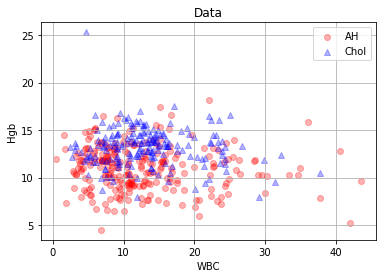

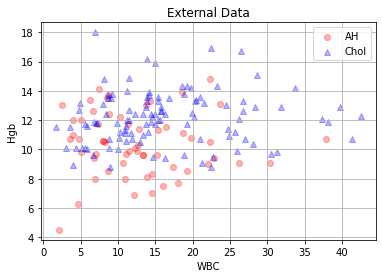

In [11]:
draw_data(X[y == 0], X[y == 1], feature1 = 0, feature2 = 1, title_str='Data')
# plt.xlim(-3, 3)
# plt.ylim(-3, 3)
plt.grid(True)

draw_data(extX[exty == 0], extX[exty == 1], feature1 = 0, feature2 = 1, title_str='External Data')
# plt.xlim(-3, 3)
# plt.ylim(-3, 3)
plt.grid(True)


In [12]:
labels = torch.tensor(y).float().to(dev)
# data = torch.tensor(X).float().to(dev)
data = torch.log(torch.tensor(X).float().to(dev))
print(labels.shape, data.shape)

torch.Size([454]) torch.Size([454, 10])


In [13]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, d = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, d).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)
    
    def backward_cfg(self, x, t, c, c_mask):   # Classifier-free guidance
        return self.network(x, t, c, c_mask)

In [14]:
class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [15]:
class epsilon_diffuse(nn.Module): # all the dependencies from torch will be given to this class [parent class] # nn.Module contains all the building block of neural networks:
  def __init__(self, input_dim, output_dim, T, ns_layer=[10,5,3], t_embed_dim=8, c_embed_dim=3):
    super(epsilon_diffuse,self).__init__()  # building connection with parent and child classes
    self.T = T
    self.fc1=nn.Linear(input_dim, ns_layer[0], bias=True)       # hidden layer 1
    self.fc2=nn.Linear(ns_layer[0], ns_layer[1], bias=True)     # hidden layer 2
    self.fc3=nn.Linear(ns_layer[1], ns_layer[2], bias=True)     # hidden layer 3
    self.fc4=nn.Linear(ns_layer[2], output_dim)          # last layer

    self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim)
    self.t_emb1 = EmbedBlock(t_embed_dim, ns_layer[0])
    self.t_emb2 = EmbedBlock(t_embed_dim, ns_layer[1])
    self.c_embed1 = EmbedBlock(c_embed_dim, ns_layer[0])  # dim n_classes -> dim layer
    self.c_embed2 = EmbedBlock(c_embed_dim, ns_layer[1])  # dim n_classes -> dim layer

  def forward(self, x, t, c, c_mask):
    t = t.float() / self.T  # Convert from [0, T] to [0, 1]
    t = self.sinusoidaltime(t)
    t_emb1 = self.t_emb1(t)
    t_emb2 = self.t_emb2(t)

    c = c*c_mask
    c_emb1 = self.c_embed1(c)
    c_emb2 = self.c_embed2(c)

    out=torch.relu(self.fc1(x))              # input * weights + bias for layer 1
    out=torch.relu(self.fc2(c_emb1*out + t_emb1))            # input * weights + bias for layer 2
    out=torch.relu(self.fc3(c_emb2*out + t_emb2))            # input * weights + bias for layer 3
    out=self.fc4(out)                        # input * weights + bias for last layer
    return out                               # final outcome


In [16]:
# Diffuse data
T_col = 8
# T_row = 10
T_row = 100
T = T_col*T_row
B_start = 0.0001
B_end = 0.02


In [17]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
#             nn.Unflatten(1, (emb_dim, 1, 1)),
            nn.Unflatten(1, (emb_dim,))  # Noh, corrected
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [18]:
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
input_dim=data.shape[1]
output_dim=data.shape[1]

# ddpm = MyDDPM(epsilon_diffuse(input_dim, output_dim, T, ns_layer=[2000,2000,2000,2000,2000,2000], c_embed_dim=2), \
#               n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)


In [19]:
class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [20]:
class epsilon_diffuse(nn.Module): # all the dependencies from torch will be given to this class [parent class] # nn.Module contains all the building block of neural networks:
  def __init__(self, input_dim, output_dim, T, ns_layer=[10,5,3], t_embed_dim=8, c_embed_dim=3):
    super(epsilon_diffuse,self).__init__()  # building connection with parent and child classes
    self.T = T
    self.fc1=nn.Linear(input_dim, ns_layer[0], bias=True)       # hidden layer 1
    self.fc2=nn.Linear(ns_layer[0], ns_layer[1], bias=True)     # hidden layer 2
    self.fc3=nn.Linear(ns_layer[1], ns_layer[2], bias=True)     # hidden layer 3
    self.fc4=nn.Linear(ns_layer[2], output_dim)          # last layer

    self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim)
    self.t_emb1 = EmbedBlock(t_embed_dim, ns_layer[0])
    self.t_emb2 = EmbedBlock(t_embed_dim, ns_layer[1])
    self.c_embed1 = EmbedBlock(c_embed_dim, ns_layer[0])  # dim n_classes -> dim layer
    self.c_embed2 = EmbedBlock(c_embed_dim, ns_layer[1])  # dim n_classes -> dim layer

  def forward(self, x, t, c, c_mask):
    t = t.float() / self.T  # Convert from [0, T] to [0, 1]
    t = self.sinusoidaltime(t)
    t_emb1 = self.t_emb1(t)
    t_emb2 = self.t_emb2(t)

    c = c*c_mask
    c_emb1 = self.c_embed1(c)
    c_emb2 = self.c_embed2(c)

    out=torch.relu(self.fc1(x))              # input * weights + bias for layer 1
    out=torch.relu(self.fc2(c_emb1*out + t_emb1))            # input * weights + bias for layer 2
    out=torch.relu(self.fc3(c_emb2*out + t_emb2))            # input * weights + bias for layer 3
    out=self.fc4(out)                        # input * weights + bias for last layer
    return out                               # final outcome


In [21]:
network_layer_sizes=[2000,2000,2000,2000,2000,2000]

best_model = MyDDPM(epsilon_diffuse(input_dim, output_dim, T, ns_layer=network_layer_sizes, c_embed_dim=2), \
                    n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)
store_path = "ddpm_AH_C_cfg.pt"
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

Model loaded


In [22]:
def get_context_mask(c, drop_prob, n_classes=2, device='cpu'):
    c_hot = F.one_hot(c.to(torch.int64), num_classes=n_classes).to(device)
    c_mask = torch.bernoulli(torch.ones_like(c_hot).float() - drop_prob).to(device)
    return c_hot, c_mask

In [23]:
# with w
def generate_new_data_cfg(ddpm, n_samples, labels, n_classes=2, \
                          device=None, frames_per_gif=100, \
                          d=2, w_val = 0.):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, d).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            c_drop_prob = 0 
            c_hot, c_mask = get_context_mask(labels, c_drop_prob, device=device)
            eta_theta_keep_class = ddpm.backward_cfg(x, time_tensor, c_hot, c_mask)
            c_mask = torch.zeros_like(c_mask) 
            eta_theta_drop_class = ddpm.backward_cfg(x, time_tensor, c_hot, c_mask)
            eta_theta = (1 + w_val) * eta_theta_keep_class - w_val * eta_theta_drop_class

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, d).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

    return x

#### Data generation with $w = 0$.

In [24]:
w_val = 0.
n_gen = 5000
# n_gen = 3000
# n_gen = 2000
gen_labels = torch.cat([torch.zeros(int(n_gen/2)), torch.ones(int(n_gen/2))])
generated = generate_new_data_cfg(
        best_model, n_gen, gen_labels,
        n_classes=n_classes,
        device=device,
        d = data.shape[1], 
        w_val = w_val
    )

In [25]:
df = pd.DataFrame(torch.cat([generated, gen_labels.to(dev).reshape([-1,1])], axis=1), columns=AllFeatures)
# Save the DataFrame to a CSV file
df.to_csv('AH_Chol_Diffusion_synthesized_data.csv', index=False)  # Set index=False to avoid writing row indices to the CSV file
df


,WBC,Hgb,MCV,Plt,Alb,AST,ALT,AP,Tb,Db,Class
0,"tensor(1.5050, device='cuda:1')","tensor(2.1662, device='cuda:1')","tensor(4.5670, device='cuda:1')","tensor(4.8344, device='cuda:1')","tensor(0.8035, device='cuda:1')","tensor(5.0431, device='cuda:1')","tensor(3.9522, device='cuda:1')","tensor(5.8154, device='cuda:1')","tensor(1.2687, device='cuda:1')","tensor(1.0678, device='cuda:1')","tensor(0., device='cuda:1')"
1,"tensor(2.4158, device='cuda:1')","tensor(2.4025, device='cuda:1')","tensor(4.7379, device='cuda:1')","tensor(5.0458, device='cuda:1')","tensor(0.6666, device='cuda:1')","tensor(5.7898, device='cuda:1')","tensor(4.7893, device='cuda:1')","tensor(5.1991, device='cuda:1')","tensor(3.5259, device='cuda:1')","tensor(3.0657, device='cuda:1')","tensor(0., device='cuda:1')"
2,"tensor(3.3802, device='cuda:1')","tensor(2.3678, device='cuda:1')","tensor(4.6326, device='cuda:1')","tensor(4.7751, device='cuda:1')","tensor(0.8919, device='cuda:1')","tensor(4.7048, device='cuda:1')","tensor(4.0584, device='cuda:1')","tensor(5.8891, device='cuda:1')","tensor(3.7486, device='cuda:1')","tensor(3.4274, device='cuda:1')","tensor(0., device='cuda:1')"
3,"tensor(2.7661, device='cuda:1')","tensor(2.1020, device='cuda:1')","tensor(4.4731, device='cuda:1')","tensor(4.3009, device='cuda:1')","tensor(1.0857, device='cuda:1')","tensor(4.1907, device='cuda:1')","tensor(3.0388, device='cuda:1')","tensor(4.7920, device='cuda:1')","tensor(3.1846, device='cuda:1')","tensor(2.8426, device='cuda:1')","tensor(0., device='cuda:1')"
4,"tensor(1.3068, device='cuda:1')","tensor(2.0611, device='cuda:1')","tensor(4.5537, device='cuda:1')","tensor(3.0376, device='cuda:1')","tensor(1.1765, device='cuda:1')","tensor(5.3856, device='cuda:1')","tensor(4.1325, device='cuda:1')","tensor(4.2493, device='cuda:1')","tensor(2.3659, device='cuda:1')","tensor(2.1331, device='cuda:1')","tensor(0., device='cuda:1')"
...,...,...,...,...,...,...,...,...,...,...,...
4995,"tensor(2.2796, device='cuda:1')","tensor(2.5185, device='cuda:1')","tensor(4.5563, device='cuda:1')","tensor(5.2688, device='cuda:1')","tensor(1.3757, device='cuda:1')","tensor(4.7181, device='cuda:1')","tensor(5.5412, device='cuda:1')","tensor(5.2561, device='cuda:1')","tensor(1.7123, device='cuda:1')","tensor(1.5944, device='cuda:1')","tensor(1., device='cuda:1')"
4996,"tensor(3.0159, device='cuda:1')","tensor(2.3202, device='cuda:1')","tensor(4.6544, device='cuda:1')","tensor(5.3069, device='cuda:1')","tensor(1.1256, device='cuda:1')","tensor(4.6880, device='cuda:1')","tensor(5.8333, device='cuda:1')","tensor(5.3911, device='cuda:1')","tensor(1.5968, device='cuda:1')","tensor(1.3356, device='cuda:1')","tensor(1., device='cuda:1')"
4997,"tensor(2.2668, device='cuda:1')","tensor(2.5168, device='cuda:1')","tensor(4.4813, device='cuda:1')","tensor(5.1580, device='cuda:1')","tensor(0.8177, device='cuda:1')","tensor(4.6349, device='cuda:1')","tensor(3.7096, device='cuda:1')","tensor(6.7492, device='cuda:1')","tensor(1.8351, device='cuda:1')","tensor(1.6228, device='cuda:1')","tensor(1., device='cuda:1')"
4998,"tensor(3.2905, device='cuda:1')","tensor(2.7023, device='cuda:1')","tensor(4.5994, device='cuda:1')","tensor(5.4106, device='cuda:1')","tensor(0.9731, device='cuda:1')","tensor(5.0359, device='cuda:1')","tensor(5.0943, device='cuda:1')","tensor(5.4598, device='cuda:1')","tensor(1.7490, device='cuda:1')","tensor(1.8653, device='cuda:1')","tensor(1., device='cuda:1')"


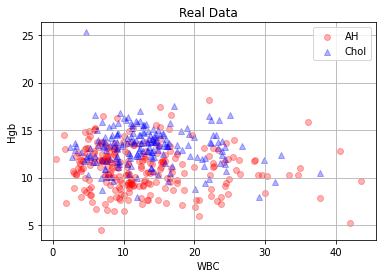

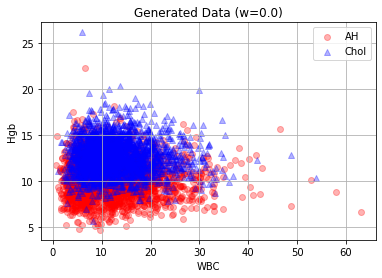

In [26]:
plot_data = torch.exp(data)
# plot_data = data
draw_data(plot_data[labels==0].cpu(), plot_data[labels==1].cpu(), \
          feature1 = 0, feature2 = 1, title_str='Real Data')
plt.grid(True)
plt.show()

plot_data = torch.exp(generated)
# plot_data = generated
fig_title = "Generated Data (w=" + str(w_val) + ")"
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 0, feature2 = 1, title_str=fig_title)
plt.grid(True)
plt.show()

1. Cross validation

In [27]:
k_fold_num = 5
kf = KFold(n_splits=5, shuffle=True)
# kf = KFold(n_splits=10, shuffle=True)
# kf = KFold(n_splits=5, shuffle=False)
kf.get_n_splits(X)
print(kf)

KFold(n_splits=5, random_state=None, shuffle=True)


In [28]:
knn_acc_mean = 0
logistic_acc_mean = 0
svm_acc_mean = 0
dt_acc_mean = 0
gnb_acc_mean = 0
nnet_acc_mean = 0
rf_acc_mean = 0

for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "\nTEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # normalize
    mean_normalize = np.mean(X_train,0)
    std_normalize = np.std(X_train,0)
    X_train = (X_train - mean_normalize)/std_normalize
    X_test = (X_test - mean_normalize)/std_normalize

    ################### Classification Start ##################
    # k-NN
    n_neighbors = 7
#     n_neighbors = 1
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
    clf.fit(X_train, y_train)    
    y_pred = clf.predict(X_test)    
    confusion_mat = confusion_matrix(y_test, y_pred)
    accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
    knn_acc_mean += accuracy/k_fold_num

    # logistic regression
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
    logistic_acc_mean += accuracy/k_fold_num

    # SVM
    clf = svm.SVC(kernel='rbf')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
    svm_acc_mean += accuracy/k_fold_num

    # Decision tree
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
    dt_acc_mean += accuracy/k_fold_num
    
    # Naive Bayes (Gaussiam)
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
    gnb_acc_mean += accuracy/k_fold_num

    # (Fully Connected) Neural Networks
    clf = MLPClassifier(solver='lbfgs', alpha=1e-10,
                     hidden_layer_sizes=(7,5,2,), random_state=1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
    nnet_acc_mean += accuracy/k_fold_num
    
    # Random Forest
    clf = RandomForestClassifier(max_depth=5, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
    rf_acc_mean += accuracy/k_fold_num

# print('\naccuracy')
print('Cross validation with data')
print('knn', knn_acc_mean)
print('logistic', logistic_acc_mean)
print('svm', svm_acc_mean)
print('dt', dt_acc_mean)
print('gnb', gnb_acc_mean)
print('neural networks', nnet_acc_mean)
print('random forest', rf_acc_mean)


Cross validation with data
knn 0.9031013431013433
logistic 0.9229059829059829
svm 0.9317216117216117
dt 0.8744566544566544
gnb 0.8787789987789989
neural networks 0.9207326007326008
random forest 0.9294993894993895


2. Train with data / test with external data

In [29]:
# normalize
mean_normalize = np.mean(X,0)
std_normalize = np.std(X,0)
X_train = (X - mean_normalize)/std_normalize
X_test = (extX - mean_normalize)/std_normalize

y_train = y
y_test = exty

################### Classification Start ##################
# k-NN
n_neighbors = 7
#     n_neighbors = 1
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
clf.fit(X_train, y_train)    
y_pred = clf.predict(X_test)    
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
knn_acc_mean = accuracy

# logistic regression
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
logistic_acc_mean = accuracy

# SVM
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
svm_acc_mean = accuracy

# Decision tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
dt_acc_mean = accuracy

# Naive Bayes (Gaussiam)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
gnb_acc_mean = accuracy

# (Fully Connected) Neural Networks
clf = MLPClassifier(solver='lbfgs', alpha=1e-10,
                 hidden_layer_sizes=(7,5,2,), random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
nnet_acc_mean = accuracy

# Random Forest
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
rf_acc_mean = accuracy

print('Train with data, test with external data')
print('knn', knn_acc_mean)
print('logistic', logistic_acc_mean)
print('svm', svm_acc_mean)
print('dt', dt_acc_mean)
print('gnb', gnb_acc_mean)
print('neural networks', nnet_acc_mean)
print('random forest', rf_acc_mean)


Train with data, test with external data
knn 0.8647058823529412
logistic 0.8823529411764706
svm 0.8647058823529412
dt 0.8235294117647058
gnb 0.6588235294117647
neural networks 0.8823529411764706
random forest 0.7823529411764706


3. Train with generated data / test with real data

In [30]:
# normalize
# mean_normalize = np.mean(generated.cpu().numpy(),0)
# std_normalize = np.std(generated.cpu().numpy(),0)
# X_train = (generated.cpu().numpy() - mean_normalize)/std_normalize
mean_normalize = np.mean(torch.exp(generated).cpu().numpy(),0)
std_normalize = np.std(torch.exp(generated).cpu().numpy(),0)
X_train = (torch.exp(generated).cpu().numpy() - mean_normalize)/std_normalize
X_test = (X - mean_normalize)/std_normalize

y_train = gen_labels
y_test = y

################### Classification Start ##################
# k-NN
# n_neighbors = 50
n_neighbors = 20
# n_neighbors = 7
#     n_neighbors = 1
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
clf.fit(X_train, y_train)    
y_pred = clf.predict(X_test)    
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
knn_acc_mean = accuracy

# logistic regression
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
logistic_acc_mean = accuracy

# SVM
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
svm_acc_mean = accuracy

# Decision tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
dt_acc_mean = accuracy

# Naive Bayes (Gaussiam)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
gnb_acc_mean = accuracy

# (Fully Connected) Neural Networks
# clf = MLPClassifier(solver='lbfgs', alpha=1e-10,
#                  hidden_layer_sizes=(7,5,2,), random_state=1)
clf = MLPClassifier(solver='lbfgs', alpha=1e-10,
                 hidden_layer_sizes=(7,5,2,), random_state=1, max_iter=2000) # max_iter default is 200
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
nnet_acc_mean = accuracy

# Random Forest
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
rf_acc_mean = accuracy

print('Train with many generated data (w=0), test with real data')
print('knn', knn_acc_mean)
print('logistic', logistic_acc_mean)
print('svm', svm_acc_mean)
print('dt', dt_acc_mean)
print('gnb', gnb_acc_mean)
print('neural networks', nnet_acc_mean)
print('random forest', rf_acc_mean)


Train with many generated data (w=0), test with real data
knn 0.9074889867841409
logistic 0.9273127753303965
svm 0.9251101321585903
dt 0.8766519823788547
gnb 0.8722466960352423
neural networks 0.9449339207048458
random forest 0.9185022026431718


4. Train with generated data / test with external data

In [31]:
# normalize
# mean_normalize = np.mean(generated.cpu().numpy(),0)
# std_normalize = np.std(generated.cpu().numpy(),0)
# X_train = (generated.cpu().numpy() - mean_normalize)/std_normalize
mean_normalize = np.mean(torch.exp(generated).cpu().numpy(),0)
std_normalize = np.std(torch.exp(generated).cpu().numpy(),0)
X_train = (torch.exp(generated).cpu().numpy() - mean_normalize)/std_normalize
X_test = (extX - mean_normalize)/std_normalize

y_train = gen_labels
y_test = exty

################### Classification Start ##################
# k-NN
# n_neighbors = 50
n_neighbors = 20
# n_neighbors = 7
#     n_neighbors = 1
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
clf.fit(X_train, y_train)    
y_pred = clf.predict(X_test)    
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
knn_acc_mean = accuracy

# logistic regression
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
logistic_acc_mean = accuracy

# SVM
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
svm_acc_mean = accuracy

# Decision tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
dt_acc_mean = accuracy

# Naive Bayes (Gaussiam)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
gnb_acc_mean = accuracy

# (Fully Connected) Neural Networks
# clf = MLPClassifier(solver='lbfgs', alpha=1e-10,
#                  hidden_layer_sizes=(7,5,2,), random_state=1)
clf = MLPClassifier(solver='lbfgs', alpha=1e-10,
                 hidden_layer_sizes=(7,5,2,), random_state=1, max_iter=2000) # max_iter default is 200
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
nnet_acc_mean = accuracy

# Random Forest
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
rf_acc_mean = accuracy

print('Train with many generated data (w=0), test with external data')
print('knn', knn_acc_mean)
print('logistic', logistic_acc_mean)
print('svm', svm_acc_mean)
print('dt', dt_acc_mean)
print('gnb', gnb_acc_mean)
print('neural networks', nnet_acc_mean)
print('random forest', rf_acc_mean)


Train with many generated data (w=0), test with external data
knn 0.8941176470588236
logistic 0.9
svm 0.9352941176470588
dt 0.8823529411764706
gnb 0.8
neural networks 0.9235294117647059
random forest 0.8411764705882353


#### Data generation with $w = 0.5$.

In [32]:
w_val = 0.5
# n_gen = 2000
# n_gen = 3000
n_gen = 5000
gen_labels = torch.cat([torch.zeros(int(n_gen/2)), torch.ones(int(n_gen/2))])
generated = generate_new_data_cfg(
        best_model, n_gen, gen_labels,
        n_classes=n_classes,
        device=device,
        d = data.shape[1], 
        w_val = w_val
    )

In [33]:
df = pd.DataFrame(torch.cat([generated, gen_labels.to(dev).reshape([-1,1])], axis=1), columns=AllFeatures)
# Save the DataFrame to a CSV file
save_file = ("AH_Chol_Diffusion_synthesized_data_w_" + str(w_val)).replace(".", "_") + ".csv"
df.to_csv(save_file, index=False)  # Set index=False to avoid writing row indices to the CSV file


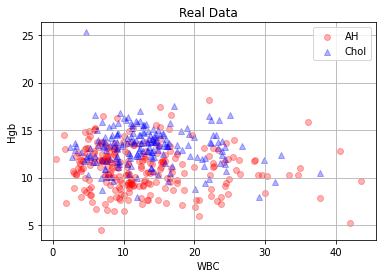

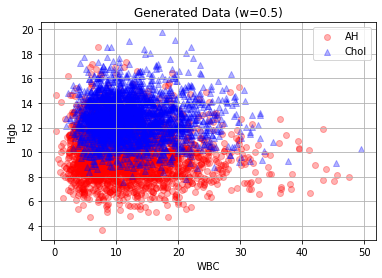

In [34]:
plot_data = torch.exp(data)
# plot_data = data
draw_data(plot_data[labels==0].cpu(), plot_data[labels==1].cpu(), \
          feature1 = 0, feature2 = 1, title_str='Real Data')
plt.grid(True)
plt.show()

plot_data = torch.exp(generated)
# plot_data = generated
fig_title = "Generated Data (w=" + str(w_val) + ")"
draw_data(plot_data[gen_labels==0].cpu(), plot_data[gen_labels==1].cpu(), \
          feature1 = 0, feature2 = 1, title_str=fig_title)
plt.grid(True)
plt.show()

1. Train with generated data / test with real data

In [35]:
# normalize
# mean_normalize = np.mean(generated.cpu().numpy(),0)
# std_normalize = np.std(generated.cpu().numpy(),0)
# X_train = (generated.cpu().numpy() - mean_normalize)/std_normalize
mean_normalize = np.mean(torch.exp(generated).cpu().numpy(),0)
std_normalize = np.std(torch.exp(generated).cpu().numpy(),0)
X_train = (torch.exp(generated).cpu().numpy() - mean_normalize)/std_normalize
X_test = (X - mean_normalize)/std_normalize

y_train = gen_labels
y_test = y

################### Classification Start ##################
# k-NN
n_neighbors = 20
# n_neighbors = 7
#     n_neighbors = 1
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
clf.fit(X_train, y_train)    
y_pred = clf.predict(X_test)    
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
knn_acc_mean = accuracy

# logistic regression
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
logistic_acc_mean = accuracy

# SVM
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
svm_acc_mean = accuracy

# Decision tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
dt_acc_mean = accuracy

# Naive Bayes (Gaussiam)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
gnb_acc_mean = accuracy

# (Fully Connected) Neural Networks
clf = MLPClassifier(solver='lbfgs', alpha=1e-10,
                 hidden_layer_sizes=(7,5,2,), random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
nnet_acc_mean = accuracy

# Random Forest
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
rf_acc_mean = accuracy

print('Train with many generated data (w=0.5), test with real data')
print('knn', knn_acc_mean)
print('logistic', logistic_acc_mean)
print('svm', svm_acc_mean)
print('dt', dt_acc_mean)
print('gnb', gnb_acc_mean)
print('neural networks', nnet_acc_mean)
print('random forest', rf_acc_mean)


Train with many generated data (w=0.5), test with real data
knn 0.8832599118942731
logistic 0.920704845814978
svm 0.9185022026431718
dt 0.8876651982378855
gnb 0.8656387665198237
neural networks 0.920704845814978
random forest 0.9118942731277533


2. Train with generated data / test with external data

In [36]:
# normalize
# mean_normalize = np.mean(generated.cpu().numpy(),0)
# std_normalize = np.std(generated.cpu().numpy(),0)
# X_train = (generated.cpu().numpy() - mean_normalize)/std_normalize
mean_normalize = np.mean(torch.exp(generated).cpu().numpy(),0)
std_normalize = np.std(torch.exp(generated).cpu().numpy(),0)
X_train = (torch.exp(generated).cpu().numpy() - mean_normalize)/std_normalize
X_test = (extX - mean_normalize)/std_normalize

y_train = gen_labels
y_test = exty

################### Classification Start ##################
# k-NN
n_neighbors = 20
# n_neighbors = 7
#     n_neighbors = 1
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
clf.fit(X_train, y_train)    
y_pred = clf.predict(X_test)    
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
knn_acc_mean = accuracy

# logistic regression
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
logistic_acc_mean = accuracy

# SVM
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
svm_acc_mean = accuracy

# Decision tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
dt_acc_mean = accuracy

# Naive Bayes (Gaussiam)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
gnb_acc_mean = accuracy

# (Fully Connected) Neural Networks
clf = MLPClassifier(solver='lbfgs', alpha=1e-10,
                 hidden_layer_sizes=(7,5,2,), random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
nnet_acc_mean = accuracy

# Random Forest
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = (confusion_mat[0,0] + confusion_mat[1,1])/sum(sum(confusion_mat))
rf_acc_mean = accuracy

print('Train with many generated data (w=0.5), test with external data')
print('knn', knn_acc_mean)
print('logistic', logistic_acc_mean)
print('svm', svm_acc_mean)
print('dt', dt_acc_mean)
print('gnb', gnb_acc_mean)
print('neural networks', nnet_acc_mean)
print('random forest', rf_acc_mean)


Train with many generated data (w=0.5), test with external data
knn 0.8588235294117647
logistic 0.8764705882352941
svm 0.888235294117647
dt 0.788235294117647
gnb 0.7764705882352941
neural networks 0.9058823529411765
random forest 0.8176470588235294
